In [1]:
# Standard Imports
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

# # UtilsTHank yuThanT
# from pyspecter.utils.data_utils import load_cmsopendata, load_triangles, kT_N

from pyspecter.CommonObservables import build_event_observables, build_jet_observables
from pyspecter.SpectralEMD_Helper import compute_spectral_representation


from rikabplotlib.plot_utils import newplot, plot_event, hist_with_outline, stamp

2024-09-26 16:40:44.571749: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# PLOT DETAILS

In [2]:
plt.rcParams.update({'figure.autolayout': True})

# General Parameters
HISTOGRAM_LINEWIDTH = 1.5


# Algorithm Schemes

SHAPE_COLOR = "purple"
SPECTER_COLOR = "red"
HARD_SPECTER_COLOR = "darkred"
SHAPER_COLOR = "cornflowerblue"
POT_COLOR = "deeppink"


# interpolate between two colors in hsv space
def interpolate_color(color1, color2, alpha):
    color1 = plt.cm.colors.to_rgba(color1)
    color2 = plt.cm.colors.to_rgba(color2)
    return plt.cm.colors.to_hex(np.array(plt.cm.colors.to_rgba(color1)) * (1 - alpha) + np.array(plt.cm.colors.to_rgba(color2)) * alpha)

SPECTER_SHAPER_RATIO_COLOR = interpolate_color(SPECTER_COLOR, SHAPER_COLOR, 0.5)

# Dataset Schemes

QCD_COLOR = "red"
TJETS_COLOR = "orange"
UNIFORM_COLOR = "black"
EEJETS_COLOR = "gold"

In [3]:
def qcd_stamp(ax, title, x, y, ha = "left", va = "bottom", text_fontsize = 10):

    line_0 = rf"{title}"
    line_1 = r"$\textsc{PYTHIA 8.3}$"
    line_2 = r"QCD AK10 Jets, $\sqrt{s} = 14$ TeV"
    line_3 = r"$|\eta| < 2.5, p_T \in [500, 550]$ GeV"
    stamp(x, y, ax, line_0 = line_0, line_1 = line_1, line_2 = line_2, line_3 = line_3, textops_update={"horizontalalignment" : ha, "verticalalignment" : va, "fontsize" : text_fontsize})


def top_stamp(ax, title, x, y, ha = "left", va = "bottom", text_fontsize = 10):

    line_0 = rf"{title}"
    line_1 = r"$\textsc{PYTHIA 8.3}$"
    line_2 = r"Top AK10 Jets, $\sqrt{s} = 14$ TeV"
    line_3 = r"$|\eta| < 2.5, p_T \in [500, 550]$ GeV"
    stamp(x, y, ax, line_0 = line_0, line_1 = line_1, line_2 = line_2, line_3 = line_3, textops_update={"horizontalalignment" : ha, "verticalalignment" : va, "fontsize" : text_fontsize})


def ee_stamp(ax, title, x, y, ha = "left", va = "bottom", text_fontsize = 10):

    line_0 = rf"{title}"
    line_1 = r"$\textsc{PYTHIA 8.3}$"
    line_2 = r"$e^+e^- \to $ Hadrons"
    line_3 = r"$\sqrt{s} = m_Z$"
    stamp(x, y, ax, line_0 = line_0, line_1 = line_1, line_2 = line_2, line_3 = line_3, textops_update={"horizontalalignment" : ha, "verticalalignment" : va, "fontsize" : text_fontsize})


def rambo_stamp(ax, title, x, y, ha = "left", va = "bottom", text_fontsize = 10):

    line_0 = rf"{title}"
    line_1 = r"Uniform Phase Space"
    line_2 = r"$p_T = 500$ GeV, $m_J = 150$ GeV"
    stamp(x, y, ax, line_0 = line_0, line_1 = line_1, line_2 = line_2, textops_update={"horizontalalignment" : ha, "verticalalignment" : va, "fontsize" : text_fontsize})


this_dir = "/n/home01/rikab/SPECTER_STUDIES"



# Timing Plots

Batch size: 1, fit: [ 0.15864147 -7.76127396]
Batch size: 10, fit: [  0.26552671 -10.83019558]
Batch size: 100, fit: [  0.70270434 -15.82534616]
Batch size: 1000, fit: [  0.88633687 -17.67733125]
Batch size: 10000, fit: [  1.0376024  -18.70586308]
Batch size: 1, fit: [  1.51693472 -14.48308534]
Batch size: 10, fit: [  1.89696677 -17.74244043]
Batch size: 100, fit: [  1.98040844 -18.44300644]
Batch size: 1000, fit: [  1.87757313 -17.79775682]
Batch size: 10000, fit: [  1.21664028 -14.08012873]
Batch size: 1, fit: [  2.31794976 -18.14361334]
Batch size: 10, fit: [  2.31398295 -18.10986706]
Batch size: 100, fit: [  2.33154271 -18.25291341]
Batch size: 1000, fit: [  2.31959075 -18.15081144]
Batch size: 10000, fit: [  2.31323263 -18.09485174]


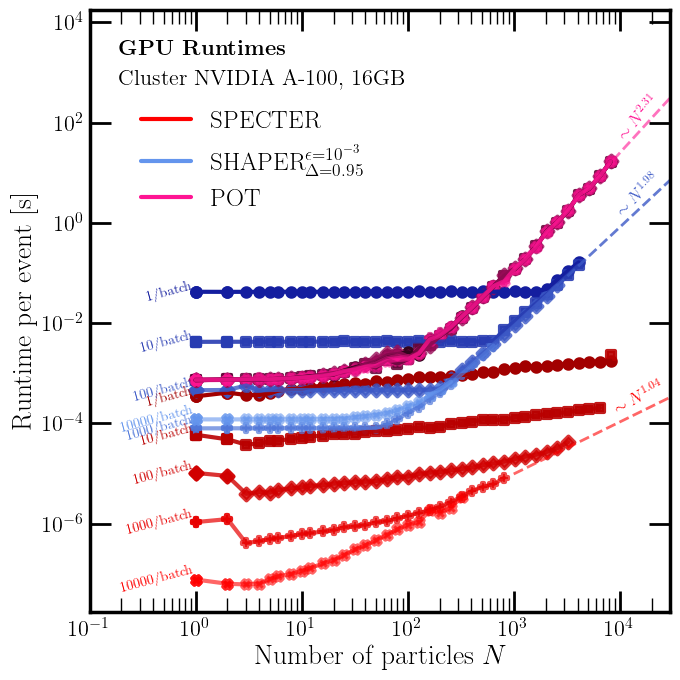

In [4]:
fig, ax = newplot("full")

N_trials = 10
R = 1
beta = 2
run_name = "gpu_base2"
batch_sizes = [1,10, 100, 1000, 10000]
num_particles = np.logspace(0, 16, 49, base = 2).astype(int)

alphas = [0, 0.2, 0.4, 0.6, 0.8]
SPECTER_colors = [interpolate_color(SPECTER_COLOR, "darkred", al) for al in alphas][::-1]
POT_colors = [interpolate_color(POT_COLOR, "black" ,al ) for al in alphas][::-1]
# Shades of violet
purple = np.array((186, 85, 211)) / 256
SHAPER_colors = [interpolate_color(SHAPER_COLOR ,"darkblue", al) for al in alphas][::-1]



alphas = [1, 0.9, 0.8, 0.7, 0.6, 0.5]
markers = ["o", "s", "D", "P", "X"]
line_styles = ["-", "--", "-.", ":", "-"]



def plot_series(model, run_name, colors):
    for batch_size in batch_sizes:


        mean_times = []

        for N_particles in num_particles:

            if N_particles < 10000:

                file =  f"Data/{model}_{N_trials}_{batch_size}_{N_particles}_{run_name}_times.npy"

                try:
                    times = np.load(file) / batch_size
                    plt.scatter(N_particles * np.ones_like(times[2:3]), times[2:3], color=colors[batch_sizes.index(batch_size)], alpha = alphas[batch_sizes.index(batch_size)], marker=markers[batch_sizes.index(batch_size)], lw = 3)
                    
                    mean_time = np.mean(times[2:3])
                    if N_particles > 1 and mean_time > mean_times[-1] * 5:
                        continue
                    
                    mean_times.append(np.mean(times[2:3]))
                    # print(f"{model} times for ", N_particles, " particles: ", times[2:3])
                except:
                    # print(f"File {file} not found")
                    pass

        mean_times = np.array(mean_times)


        plt.plot(num_particles[:mean_times.shape[0]], mean_times, color=colors[batch_sizes.index(batch_size)], alpha = alphas[batch_sizes.index(batch_size)], lw = 3)


        


        # # Big X for the last point in SHAPER
        # if model == "SHAPER":
        #     plt.scatter((num_particles[:mean_times.shape[0]])[-1], mean_times[-1], color="black", alpha = alphas[batch_sizes.index(batch_size)], marker="X", s=250, lw = 2)


        # Fit to power law

        try:
            log_N = np.log(num_particles[mean_times.shape[0] - 5:mean_times.shape[0]])
            log_t = np.log(mean_times[mean_times.shape[0] - 5:])
            fit = np.polyfit(log_N, log_t, 1)
            print(f"Batch size: {batch_size}, fit: {fit}")


            if (batch_size == 100 and model == "SHAPER") or (batch_size == 10000 and model != "SHAPER"):
                xs = np.linspace(1000, 100000, 100)
                ys = np.exp(fit[1]) * xs ** fit[0]
                # print(xs, ys)
                plt.plot(xs, ys, ms = 100, color=colors[batch_sizes.index(batch_size)], linestyle="--", alpha = alphas[batch_sizes.index(batch_size)], lw = 2)           

                # Get aspect ratio of plot
                ax = plt.gca()
                aspect = ax.get_aspect()

                # Get angle of line 
                angle = np.arctan(fit[0] / 2) * 180 / np.pi


                # Text Showing fit to the right of the last point
                x = 15000
                y = np.exp(fit[1]) * x ** fit[0]
                plt.text(x, y * 2, r"$\sim N^{%.2f}$" % fit[0], color=colors[batch_sizes.index(batch_size)], rotation=angle, fontsize=12, ha="center", va = "center") 

            # plt.text(num_particles[4], mean_times[4] * 2, r"Batch Size %d, $\sim N^{%.2f}$" % (batch_size, fit[0]), color=colors[batch_sizes.index(batch_size)], rotation=50, fontsize=14, ha="center", va = "center")


        except:
            print(f"Batch size: {batch_size}, fit: None")


        # Text Showing batch size to the left of the first point
        if not model == "POT":
            plt.text(num_particles[0] * 0.99, mean_times[0], f"{batch_size}/batch", color=colors[batch_sizes.index(batch_size)], rotation=15, fontsize=10, ha="right", va = "center")



plot_series("SPECTER", "cpu", SPECTER_colors)
plot_series("SHAPER", "cpu", SHAPER_colors)
plot_series("POT", "cpu", POT_colors)




plt.xscale("log")
plt.yscale("log")
plt.xlim(0.1, 30000)

# Dummy curves for legend
plt.plot(0,0, color=SPECTER_COLOR, label=r"\textrm{SPECTER}")
plt.plot(0,0, color=SHAPER_COLOR, label=r"$\textrm{SHAPER}^{\epsilon = 10^{-3}}_{\Delta = 0.95}$")
plt.plot(0,0, color=POT_COLOR, label=r"$\textrm{POT}$")

plt.legend(fontsize=18, loc = "center left", bbox_to_anchor=(0.05, 0.75))

# Text
plt.text(0.05, 0.95, r"\textbf{GPU Runtimes}", ha = "left", va = "top", transform = ax.transAxes)
plt.text(0.05, 0.9, r"Cluster NVIDIA A-100, 16GB", ha = "left", va = "top", transform = ax.transAxes)

plt.xlabel("Number of particles $N$")
plt.ylabel("Runtime per event [s]")

plt.savefig("Figures/GPU_runtimes.pdf")

# Load Data to make plots

In [5]:
def spherical_coordinates(data):
    p = data[:, :, 1:]
    r = np.linalg.norm(p, axis=-1)
    data[:,:,0] = r
    theta = np.arccos(p[:, :, 2] / r)
    phi = np.arctan2(p[:, :, 1], p[:, :, 0])

    spherical_data = np.stack([r, theta, phi], axis=-1)
    return spherical_data


In [6]:
jets_dir = "/n/holyscratch01/iaifi_lab/rikab/.energyflow"

R = 0.8

# Load the data
N_data = 100


data_directory = "/n/holyscratch01/iaifi_lab/rikab/top_qcd/top_qcd_0.npz"
this_dir = "/n/home01/rikab/SPECTER_STUDIES"

def load_data():

    d = np.load(data_directory)
    X = np.array(d["data"])
    Y = d["labels"]


    qcd = X[Y == 0][:N_data,:75,:3]
    top = X[Y == 1][:N_data,:75,:3]

    # delete X, Y, d to save memory
    del X
    del Y
    del d

    return qcd, top

qcd, top = load_data()

jets_dataset = qcd

for x in jets_dataset:

    energies = x[:,0]
    etas = x[:,1]
    phis = x[:,2]

    x[:,0] = energies / np.sum(energies)
    x[:,1] = etas - np.average(etas, weights=energies)
    x[:,2] = phis - np.average(phis, weights=energies)

    # zero out if the energy is zero
    x[:,1][energies == 0] = 0
    x[:,2][energies == 0] = 0

for x in top:

    energies = x[:,0]
    etas = x[:,1]
    phis = x[:,2]

    x[:,0] = energies / np.sum(energies)
    x[:,1] = etas - np.average(etas, weights=energies)
    x[:,2] = phis - np.average(phis, weights=energies)

    # zero out if the energy is zero
    x[:,1][energies == 0] = 0
    x[:,2][energies == 0] = 0


# Events
events_dir = "/n/holyscratch01/iaifi_lab/rikab/top/top_events.npy"
events_dir = "/n/holyscratch01/iaifi_lab/rikab/ee_dijets/lep_dijets.npy"

events_dataset = np.load(events_dir, allow_pickle = True)[:N_data]

for (i, x) in tqdm(enumerate(events_dataset)):

    theta = np.arccos(x[:,3] / x[:,0])
    eta = -np.log(np.tan(theta / 2))

    ETA_MAX = 4
    eta_cut = np.abs(eta) < ETA_MAX
    x = x * eta_cut[:,None]


    energies = x[:,0]
    total_energy = np.sum(energies)
    x[:,0] = energies / total_energy
    x[:,1] = x[:,1] / total_energy
    x[:,2] = x[:,2] / total_energy
    x[:,3] = x[:,3] / total_energy

    # Sort x by x[:,0] in descending order
    x = x[np.argsort(x[:,0])[::-1]]

    events_dataset[i] = x

events_dataset = events_dataset[:,:250]


0it [00:00, ?it/s]/tmp/ipykernel_2035010/473497716.py:70: RuntimeWarning: invalid value encountered in divide
  theta = np.arccos(x[:,3] / x[:,0])
100it [00:00, 13146.64it/s]


In [7]:
# jets_dir = "/n/holyscratch01/iaifi_lab/rikab/.energyflow"

# R = 0.8

# # Load the data
# N_data = 100


# data_directory = "/n/holyscratch01/iaifi_lab/rikab/top_qcd/top_qcd_0.npz"
# this_dir = "/n/home01/rikab/SPECTER_STUDIES"

# d = np.load(data_directory)
# X = np.array(d["data"])
# Y = d["labels"]

# qcd = X[Y == 0][:N_data,:75,:3]
# top = X[Y == 1][:N_data,:75,:3]

# jets_dataset = qcd

# for x in jets_dataset:

#     energies = x[:,0]
#     etas = x[:,1]
#     phis = x[:,2]

#     x[:,0] = energies / np.sum(energies)
#     x[:,1] = etas - np.average(etas, weights=energies)
#     x[:,2] = phis - np.average(phis, weights=energies)

#     # zero out if the energy is zero
#     x[:,1][energies == 0] = 0
#     x[:,2][energies == 0] = 0

# # Events
# events_dir = "/n/holyscratch01/iaifi_lab/rikab/top/top_events.npy"
# events_dataset = np.load(events_dir, allow_pickle = True)[:N_data]

# for x in events_dataset:

#     theta = np.arccos(x[:,3] / x[:,0])
#     eta = -np.log(np.tan(theta / 2))

#     ETA_MAX = 2
#     eta_cut = np.abs(eta) < ETA_MAX

#     total_energy = np.sum(x[:,0])
#     x[:,0] = x[:,0] / total_energy
#     x[:,1] = x[:,1] / total_energy
#     x[:,2] = x[:,2] / total_energy
#     x[:,3] = x[:,3] / total_energy

#     # Sort x by x[:,0]
#     x = x[np.argsort(x[:,0])]




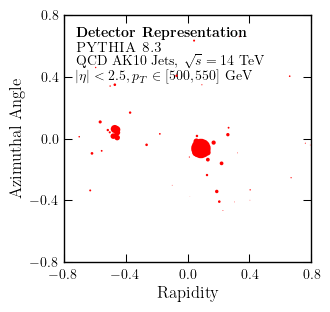

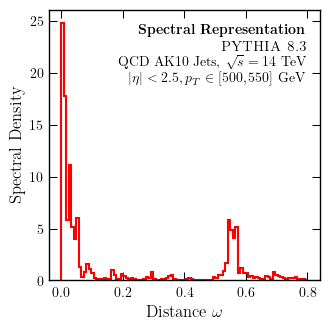

In [8]:


example_jet = jets_dataset[0]
example_jet_spectral = compute_spectral_representation(example_jet)

# Plot Jet Representaiton
fig, ax = newplot("column")
qcd_stamp(ax, "Detector Representation", 0.05, 0.9)
plot_event(ax, example_jet, R, show = False, color= QCD_COLOR)
ax.set_box_aspect(1)
plt.savefig("Figures/Picture_Day/jet_detector_representation.pdf")

fig, ax = newplot("column")
plt.hist(example_jet_spectral[:,0], weights = example_jet_spectral[:,1], bins = np.linspace(0, R, 100), histtype = "step", color = QCD_COLOR, density = True, lw = HISTOGRAM_LINEWIDTH)
plt.xlabel(r"Distance $\omega$")
plt.ylabel(r"Spectral Density")
qcd_stamp(ax, "Spectral Representation", 0.95, 0.9, ha = "right")
ax.set_box_aspect(1)

plt.savefig("Figures/Picture_Day/jet_spectral_representation.pdf")





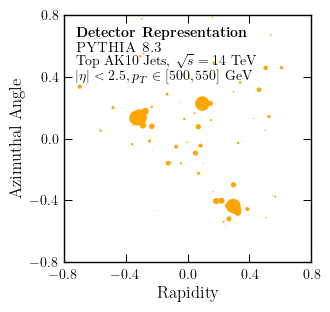

In [9]:
# Plot Jet Representaiton
fig, ax = newplot("column")
top_stamp(ax, "Detector Representation", 0.05, 0.9)
plot_event(ax, top[5], R, show = False, color= TJETS_COLOR)
ax.set_box_aspect(1)
# plt.savefig("Figures/Picture_Day/jet_detector_representation.pdf")

/tmp/ipykernel_2035010/1091981352.py:5: RuntimeWarning: invalid value encountered in divide
  theta = np.arccos(p[:, :, 2] / r)
/n/home01/rikab/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:3638: RuntimeWarning: invalid value encountered in divide
  return sin(y)/y
/n/home01/rikab/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:3638: RuntimeWarning: invalid value encountered in divide
  return sin(y)/y


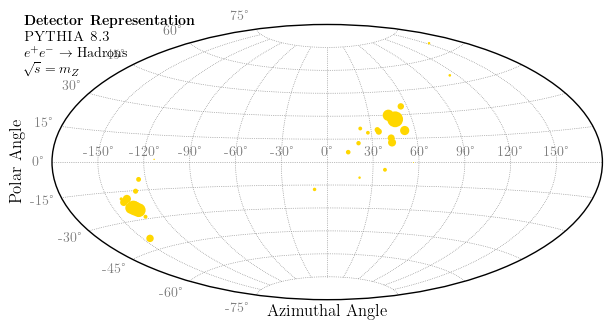

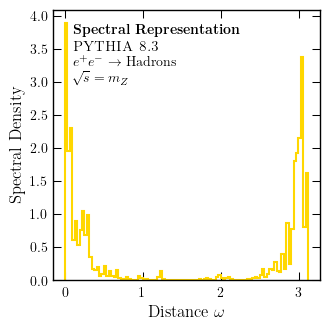

In [10]:
event_number = 1
events_dataset = events_dataset[:,:250]

spherical_events = spherical_coordinates(events_dataset)
example_event = spherical_events[event_number]
example_event_spectral = compute_spectral_representation(events_dataset[event_number], euclidean = False)


# Plot Event Representation
fig, ax = newplot("column", subplot_kw = {"projection" :"aitoff"}, aspect_ratio= 1/2)

pts, ys, phis = example_event[:,0], example_event[:, 1], example_event[:, 2]
ax.scatter(phis, ys - np.pi/2, marker='o', s=2 * pts * 500/np.sum(pts), color=EEJETS_COLOR, lw=0, zorder=10, label="Event")
plt.xlabel("Azimuthal Angle")
plt.ylabel("Polar Angle")
ee_stamp(ax, "Detector Representation", -0.05, 0.99)

ax.grid(True, which='both', color='gray', linestyle=':', linewidth=0.5)

# Make ticklabels fainter
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontsize(10)
    label.set_alpha(0.5)

plt.savefig("Figures/Picture_Day/event_detector_representation.pdf")

fig, ax = newplot("column")
plt.hist(example_event_spectral[:,0], weights = example_event_spectral[:,1], bins = 100, histtype = "step", color = EEJETS_COLOR, density = True, lw = 1.5)
plt.xlabel(r"Distance $\omega$")
plt.ylabel(r"Spectral Density")
ee_stamp(ax, "Spectral Representation", 0.075, 0.9, ha = "left")
plt.savefig("Figures/Picture_Day/event_spectral_representation.pdf")


# Observables Sampling Plots

Compiling with vmap after jit
Compiling with vmap after jit
Compiling with vmap after jit
Compiling with vmap after jit
Compiling with vmap after jit
Compiling with vmap after jit


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_2035010/3009159703.py:28: RuntimeWarning: invalid value encountered in sqrt
  exact_spectral_1sprong = 1/np.pi * 2 / np.sqrt(4 * (R/2)**2 - omegas**2)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_2035010/3009159703.py:55: RuntimeWarning: invalid value encountered in sqrt
  exact_spectral_3sprong = 1/np.pi * 2 / np.sqrt(4 * (R/2)**2 - omegas**2)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[[0.         0.6855012 ]
 [0.3802797  0.03812886]
 [0.5714055  0.26858252]
 [0.8016237  0.00778739]]


/tmp/ipykernel_2035010/3009159703.py:88: RuntimeWarning: invalid value encountered in sqrt
  exact_spectral_ring = 1/np.pi * 2 / np.sqrt(4 * (R/2)**2 - omegas**2)
/tmp/ipykernel_2035010/3009159703.py:115: RuntimeWarning: invalid value encountered in arccos
  exact_spectral_disk = 4 * omegas / np.pi / (R/2)**2 * np.arccos(omegas / 2 / (R/2)) - 2 * omegas**2 / np.pi / (R/2)**3 * np.sqrt(1 - omegas**2 / 4 / (R/2)**2)
/tmp/ipykernel_2035010/3009159703.py:115: RuntimeWarning: invalid value encountered in sqrt
  exact_spectral_disk = 4 * omegas / np.pi / (R/2)**2 * np.arccos(omegas / 2 / (R/2)) - 2 * omegas**2 / np.pi / (R/2)**3 * np.sqrt(1 - omegas**2 / 4 / (R/2)**2)


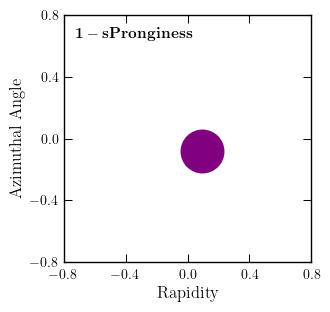

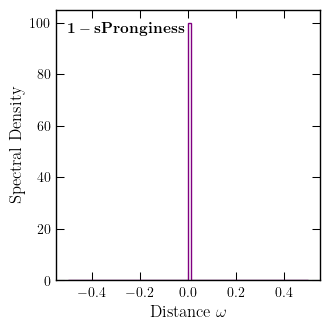

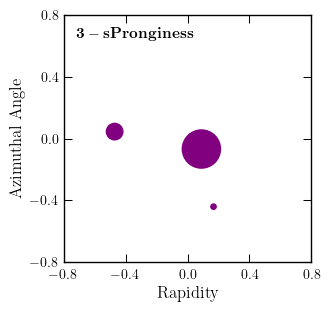

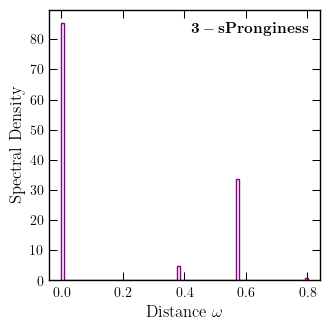

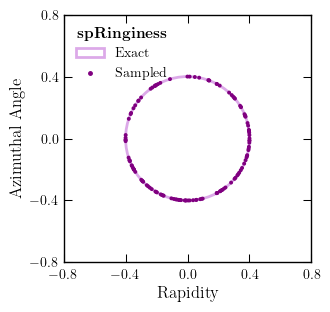

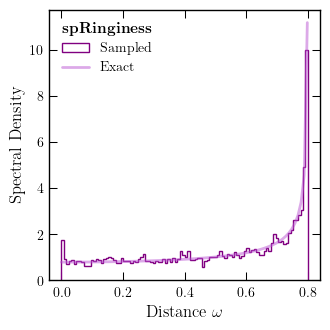

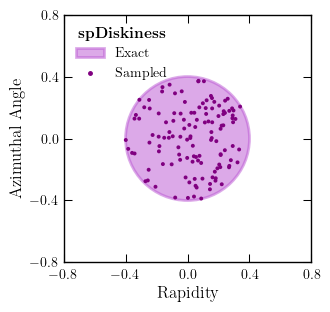

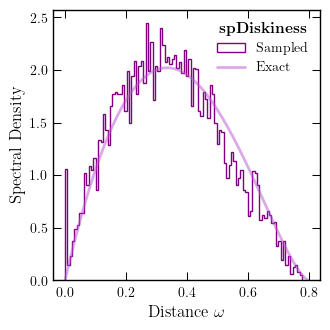

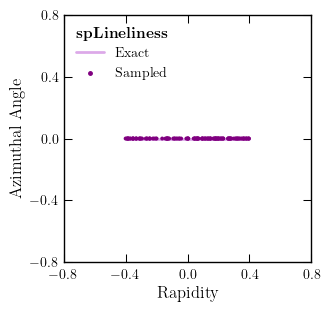

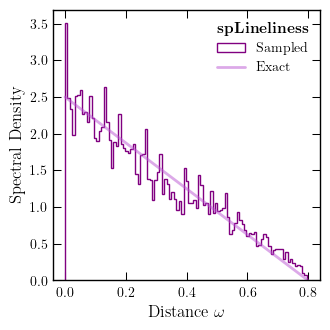

In [11]:
N_SAMPLE = 125


observables = build_jet_observables(R)

example_jet = jets_dataset[0]
example_jet_spectral = compute_spectral_representation(example_jet)



# 1-sPronginess

_1spronginess = observables["1-sPronginess"]
initial_params = _1spronginess.initializer([example_jet,], N_SAMPLE, seed = 0)
sprong_jet = _1spronginess.sampler(initial_params, N_SAMPLE, seed = 0)[0]
sprong_jet_spectral = compute_spectral_representation(sprong_jet)

fig, ax = newplot("column")
ax.scatter([], [], color = SHAPE_COLOR)
plt.legend(title = r"$\bf{1-sPronginess}$", loc = "upper left")
plot_event(ax, sprong_jet, R, color = SHAPE_COLOR, show = False)

plt.savefig("Figures/Picture_Day/1spronginess_jet_detector_representation.pdf")

fig, ax = newplot("column")
plt.hist(sprong_jet_spectral[:,0], weights = sprong_jet_spectral[:,1], bins = 100, histtype = "step", color = SHAPE_COLOR, density = True, lw = 1)
omegas = np.linspace(0,1, 100)
exact_spectral_1sprong = 1/np.pi * 2 / np.sqrt(4 * (R/2)**2 - omegas**2)
# plt.plot(omegas, exact_spectral_1sprong, color = "mediumorchid", label = "Exact", lw = 2, alpha = 0.5)
plt.xlabel(r"Distance $\omega$")
plt.ylabel(r"Spectral Density")
plt.legend(title = r"$\bf{1-sPronginess}$", loc = "upper left")
plt.savefig("Figures/Picture_Day/1spronginess_jet_spectral_representation.pdf")


# 3-sPronginess

_3spronginess = observables["3-sPronginess"]
initial_params = _3spronginess.initializer([example_jet,], N_SAMPLE, seed = 0)
sprong_jet = _3spronginess.sampler(initial_params, N_SAMPLE, seed = 0)[0]
sprong_jet_spectral = compute_spectral_representation(sprong_jet)

fig, ax = newplot("column")
ax.scatter([], [], color = SHAPE_COLOR)
plt.legend(title = r"$\bf{3-sPronginess}$", loc = "upper left")
plot_event(ax, sprong_jet, R, color = SHAPE_COLOR, show = False)

plt.savefig("Figures/Picture_Day/3spronginess_jet_detector_representation.pdf")

fig, ax = newplot("column")

print(sprong_jet_spectral)
plt.hist(sprong_jet_spectral[:,0], weights = sprong_jet_spectral[:,1], bins = 100, histtype = "step", color = SHAPE_COLOR, density = True,  lw = 1)
omegas = np.linspace(0,1, 100)
exact_spectral_3sprong = 1/np.pi * 2 / np.sqrt(4 * (R/2)**2 - omegas**2)
# plt.plot(omegas, exact_spectral_3sprong, color = "mediumorchid", label = "Exact", lw = 2, alpha = 0.5)
plt.xlabel(r"Distance $\omega$")
plt.ylabel(r"Spectral Density")
plt.legend(title = r" $\bf{3-sPronginess}$", loc = "upper right")
plt.savefig("Figures/Picture_Day/3spronginess_jet_spectral_representation.pdf")







# Ring
_springiness = observables["spRinginess"]
initial_params = _springiness.initializer(example_jet, N_SAMPLE, seed = 0)
ring_jet = _springiness.sampler(initial_params, N_SAMPLE, seed = 0)
ring_jet_spectral = compute_spectral_representation(ring_jet)

fig, ax = newplot("column")


circle = plt.Circle((0, 0), R/2, color='mediumorchid', alpha=0.5, lw = 2, fill = False, label = "Exact")
ax.add_artist(circle)
ax.scatter([], [], color = SHAPE_COLOR, label = "Sampled")
plt.legend(title = r"$\bf{spRinginess}$", loc = "upper left")
plot_event(ax, ring_jet, R, color = SHAPE_COLOR, show = False)

plt.savefig("Figures/Picture_Day/ringiness_jet_detector_representation.pdf")

fig, ax = newplot("column")
plt.hist(ring_jet_spectral[:,0], weights = ring_jet_spectral[:,1], bins = 100, histtype = "step", color = SHAPE_COLOR, density = True, label = "Sampled", lw = 1)
omegas = np.linspace(0,1, 100)
exact_spectral_ring = 1/np.pi * 2 / np.sqrt(4 * (R/2)**2 - omegas**2)
plt.plot(omegas, exact_spectral_ring, color = "mediumorchid", label = "Exact", lw = 2, alpha = 0.5)
plt.xlabel(r"Distance $\omega$")
plt.ylabel(r"Spectral Density")
plt.legend(title = r"$\bf{spRinginess}$", loc = "upper left")
plt.savefig("Figures/Picture_Day/ringiness_jet_spectral_representation.pdf")


# Disk
_disk = observables["spDiskiness"]
initial_params = _disk.initializer(example_jet, N_SAMPLE, seed = 0)
disk_jet = _disk.sampler(initial_params, N_SAMPLE, seed = 0)
disk_jet_spectral = compute_spectral_representation(disk_jet)

fig, ax = newplot("column")

circle = plt.Circle((0, 0), R/2, color='mediumorchid', alpha=0.5, lw = 2, fill = True, label = "Exact")
ax.add_artist(circle)
ax.scatter([], [], color = SHAPE_COLOR, label = "Sampled")
plt.legend(title = r"$\bf{spDiskiness}$", loc = "upper left")
plot_event(ax, disk_jet, R, color = SHAPE_COLOR, show = False)

plt.savefig("Figures/Picture_Day/diskiness_jet_detector_representation.pdf")

fig, ax = newplot("column")
plt.hist(disk_jet_spectral[:,0], weights = disk_jet_spectral[:,1], bins = 100, histtype = "step", color = SHAPE_COLOR, density = True, label = "Sampled", lw = 1)
omegas = np.linspace(0,1, 100)
exact_spectral_disk = 4 * omegas / np.pi / (R/2)**2 * np.arccos(omegas / 2 / (R/2)) - 2 * omegas**2 / np.pi / (R/2)**3 * np.sqrt(1 - omegas**2 / 4 / (R/2)**2)
plt.plot(omegas, exact_spectral_disk, color = "mediumorchid", label = "Exact", lw = 2, alpha = 0.5)
plt.xlabel(r"Distance $\omega$")
plt.ylabel(r"Spectral Density")
plt.legend(title = r"$\bf{spDiskiness}$", loc = "upper right")
plt.savefig("Figures/Picture_Day/diskiness_jet_spectral_representation.pdf")


# Line
_line = observables["spLineliness"]
initial_params = _line.initializer(example_jet, N_SAMPLE, seed = 0)
line_jet = _line.sampler(initial_params, N_SAMPLE, seed = 0)
line_jet = np.array(line_jet)
line_jet[:,1] = line_jet[:,1] - 0.4 
line_jet_spectral = compute_spectral_representation(line_jet)

fig, ax = newplot("column")

plt.plot([-R/2, R/2], [-0, 0], color='mediumorchid', alpha=0.5, lw = 2, label = "Exact")
ax.scatter([], [], color = SHAPE_COLOR, label = "Sampled")
plt.legend(title = r"$\bf{spLineliness}$", loc = "upper left")
plot_event(ax, line_jet, R, color = SHAPE_COLOR, show = False)
plt.savefig("Figures/Picture_Day/lineliness_jet_detector_representation.pdf")

fig, ax = newplot("column")
plt.hist(line_jet_spectral[:,0], weights = line_jet_spectral[:,1], bins = 100, histtype = "step", color = SHAPE_COLOR, density = True, label = "Sampled", lw = 1)
omegas = np.linspace(0,0.8, 100)
exact_spectral_line = (2 / R - 2*omegas / R**2)
plt.plot(omegas, exact_spectral_line, color = "mediumorchid", label = "Exact", lw = 2, alpha = 0.5)
plt.xlabel(r"Distance $\omega$")
plt.ylabel(r"Spectral Density")
plt.legend(title = r" $\bf{spLineliness}$", loc = "upper right")
plt.savefig("Figures/Picture_Day/lineliness_jet_spectral_representation.pdf")


/tmp/ipykernel_2035010/1091981352.py:5: RuntimeWarning: invalid value encountered in divide
  theta = np.arccos(p[:, :, 2] / r)


Compiling with vmap after jit
Compiling with vmap after jit
Compiling with vmap after jit
Compiling with vmap after jit
Compiling with vmap after jit
Compiling with vmap after jit
Compiling with vmap after jit
{'spIsotropy': <pyspecter.Observables.Observable object at 0x1504adc79e40>, 'spRinginess': <pyspecter.Observables.Observable object at 0x1505a41668f0>, '1-sPronginess': <pyspecter.Observables.Observable object at 0x1505a4165930>, '2-sPronginess': <pyspecter.Observables.Observable object at 0x1505a41655d0>, '3-sPronginess': <pyspecter.Observables.Observable object at 0x1505a4227d60>, 'sThrust': <pyspecter.Observables.Observable object at 0x1505a4225c60>, 'sDipole': <pyspecter.Observables.Observable object at 0x1505a4129d80>}


[[[ 0.01333333  2.351397   -0.8483308 ]
  [ 0.01333333  0.74570656  2.1809897 ]
  [ 0.01333333  1.7742535  -0.9948891 ]
  [ 0.01333333  1.1074256   1.029943  ]
  [ 0.01333333  2.2244644  -1.162307  ]
  [ 0.01333333  2.2639081  -1.2424314 ]
  [ 0.01333333  1.3958335  -1.7192471 ]
  [ 0.01333333  0.70034146 -3.0514808 ]
  [ 0.01333333  2.8536217   2.1037078 ]
  [ 0.01333333  1.533778   -3.0766845 ]
  [ 0.01333333  1.8236532   2.8214378 ]
  [ 0.01333333  1.9305453  -1.6018255 ]
  [ 0.01333333  0.7563886  -0.05162793]
  [ 0.01333333  2.1928713  -2.9084072 ]
  [ 0.01333333  1.7324414  -1.5065907 ]
  [ 0.01333333  2.5728896  -2.2230983 ]
  [ 0.01333333  1.7809405  -3.0506763 ]
  [ 0.01333333  1.7534252  -1.053777  ]
  [ 0.01333333  1.1082644  -0.13693458]
  [ 0.01333333  1.0346869  -0.6228364 ]
  [ 0.01333333  1.5594723   2.5749485 ]
  [ 0.01333333  2.3945415   1.6425108 ]
  [ 0.01333333  2.391139   -2.5868173 ]
  [ 0.01333333  1.9503186  -1.4583113 ]
  [ 0.01333333  0.41596875  2.1728554 ]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[[[ 0.41845703  1.5707964   0.        ]
  [ 0.58154297  1.5707964  -3.1415925 ]]]
(2,) (2,) (2,)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


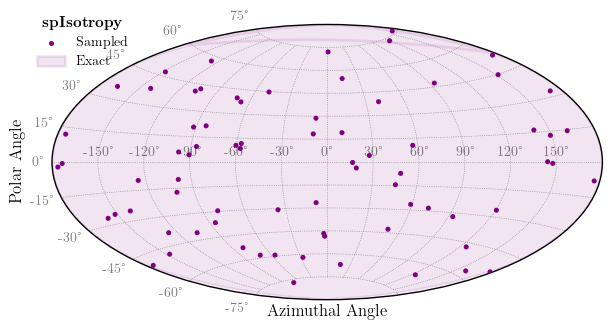

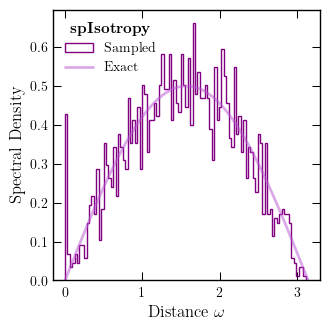

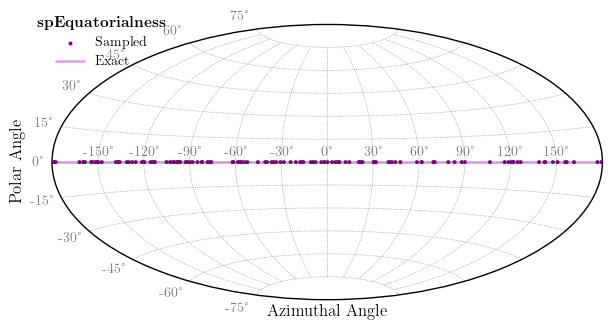

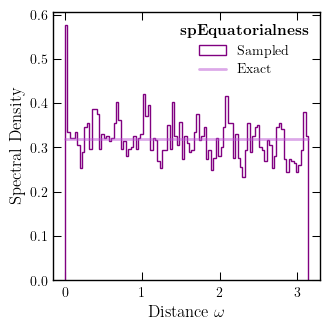

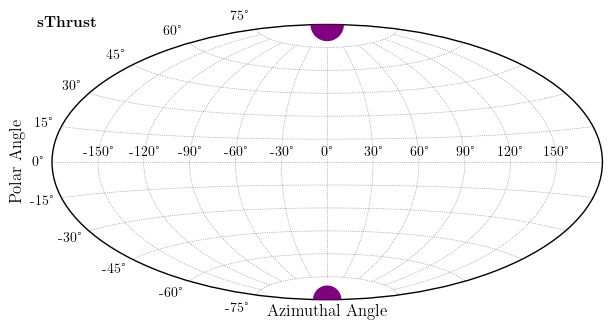

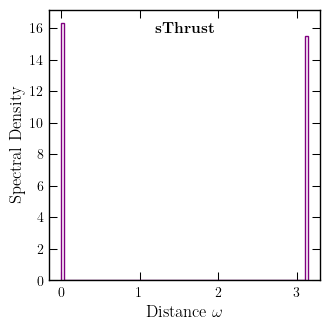

In [12]:
spherical_events = spherical_coordinates(events_dataset)
example_event = spherical_events[10]
example_event_spectral = compute_spectral_representation(events_dataset[10], euclidean = False)

event_observables = build_event_observables()
print(event_observables)

# Isotropy
_isotropy = event_observables["spIsotropy"]
initial_params = _isotropy.initializer(example_event, 75, seed = 0)
isotropy_event = _isotropy.sampler(initial_params, 75, seed = 0)
isotropy_event_spectral = compute_spectral_representation(isotropy_event, euclidean = False)

isotropy_event = np.array(isotropy_event)

# Add a dummy batch dimension
isotropy_event = isotropy_event.reshape(1, -1, 4)

spherical_isotropy = spherical_coordinates(isotropy_event)

fig, ax = newplot("column", subplot_kw = {"projection" :"aitoff"}, aspect_ratio= 1/2)


print(spherical_isotropy)
pts, ys, phis = spherical_isotropy[0,:,0], spherical_isotropy[0,:, 1], spherical_isotropy[0,:, 2]
print(pts.shape, ys.shape, phis.shape)
ax.scatter(phis, ys - np.pi/2, marker='o', s=2 * pts * 500/np.sum(pts), color="purple", lw=0, zorder=10, label="Sampled")
plt.xlabel("Azimuthal Angle")
plt.ylabel("Polar Angle")
# ee_stamp(ax, "Detector Representation", -0.05, 0.99)

# Fill the whole sphere with a purple circle
circle = plt.Circle((0, 0), np.pi, color='purple', alpha=0.1, lw = 2, fill = True, label = "Exact")
ax.add_artist(circle)

plt.legend(title = r"$\bf{spIsotropy}$", loc = "upper left", bbox_to_anchor = (-0.05,1.075))



ax.grid(True, which='both', color='gray', linestyle=':', linewidth=0.5)

# Make ticklabels fainter
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontsize(10)
    label.set_alpha(0.5)

plt.savefig("Figures/Picture_Day/isotropy_event_detector_representation.pdf")

fig, ax = newplot("column")
plt.hist(isotropy_event_spectral[:,0], weights = isotropy_event_spectral[:,1], bins = 100, histtype = "step", color = SHAPE_COLOR, density = True, lw = 1, label = "Sampled")
omegas = np.linspace(0,np.pi, 100)
exact_spectral_isotropy = 0.5 * np.sin(omegas )
plt.plot(omegas, exact_spectral_isotropy, color = "mediumorchid", label = "Exact", lw = 2, alpha = 0.5)
plt.xlabel(r"Distance $\omega$")
plt.ylabel(r"Spectral Density")
plt.legend(title = r"$\bf{spIsotropy}$", loc = "upper left")
plt.savefig("Figures/Picture_Day/isotropy_event_spectral_representation.pdf")



# Event spRinginess
_ringiness = event_observables["spRinginess"]
initial_params = _ringiness.initializer(example_event, N_SAMPLE, seed = 0)
ring_event = _ringiness.sampler(initial_params, N_SAMPLE, seed = 0)
ring_event_spectral = compute_spectral_representation(ring_event, euclidean = False)

ring_event = np.array(ring_event)

# Add a dummy batch dimension
ring_event = ring_event.reshape(1, -1, 4)

spherical_ring = spherical_coordinates(ring_event)

fig, ax = newplot("column", subplot_kw = {"projection" :"aitoff"}, aspect_ratio= 1/2)


print(spherical_ring)
pts, ys, phis = spherical_ring[0,:,0], spherical_ring[0,:, 1], spherical_ring[0,:, 2]
print(pts.shape, ys.shape, phis.shape)
ax.scatter(phis, ys - np.pi/2, marker='o', s=2 * pts * 500/np.sum(pts), color="purple", lw=0, zorder=10, label="Sampled")
plt.xlabel("Azimuthal Angle")
plt.ylabel("Polar Angle")
# ee_stamp(ax, "Detector Representation", -0.05, 0.99)

# Line at the equator
plt.plot([-np.pi, np.pi], [0, 0], color='mediumorchid', alpha=0.5, lw = 2, label = "Exact")

plt.legend(title = r"$\bf{spEquatorialness}$", loc = "upper left", bbox_to_anchor = (-0.05,1.075))

ax.grid(True, which='both', color='gray', linestyle=':', linewidth=0.5)

# Make ticklabels fainter
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontsize(10)
    label.set_alpha(0.5)

plt.savefig("Figures/Picture_Day/eringiness_event_detector_representation.pdf")

fig, ax = newplot("column")
plt.hist(ring_event_spectral[:,0], weights = ring_event_spectral[:,1], bins = 100, histtype = "step", color = SHAPE_COLOR, density = True, lw = 1, label = "Sampled")
omegas = np.linspace(0,np.pi, 100)
exact_spectral_ring = 1 / np.pi * np.ones_like(omegas)
plt.plot(omegas, exact_spectral_ring, color = "mediumorchid", label = "Exact", lw = 2, alpha = 0.5)
plt.xlabel(r"Distance $\omega$")
plt.ylabel(r"Spectral Density")
plt.legend(title = r" $\bf{spEquatorialness}$", loc = "upper right")
plt.savefig("Figures/Picture_Day/eringiness_event_spectral_representation.pdf")



# Thrust

_thrust = event_observables["sThrust"]
initial_params = _thrust.initializer(example_event, N_SAMPLE, seed = 0)
thrust_event = _thrust.sampler(initial_params, N_SAMPLE, seed = 0)
thrust_event_spectral = compute_spectral_representation(thrust_event, euclidean = False)

thrust_event = np.array(thrust_event)

# Add a dummy batch dimension
thrust_event = thrust_event.reshape(1, -1, 4)

spherical_thrust = spherical_coordinates(thrust_event)

fig, ax = newplot("column", subplot_kw = {"projection" :"aitoff"}, aspect_ratio= 1/2)


print(spherical_thrust)
pts, ys, phis = spherical_thrust[0,:,0], spherical_thrust[0,:, 1], spherical_thrust[0,:, 2]
phis = phis - phis
ys = np.array([0, np.pi])
print(pts.shape, ys.shape, phis.shape)
ax.scatter(phis, ys - np.pi/2, marker='o', s=2 * pts * 500/np.sum(pts), color="purple", lw=0, zorder=10)
plt.xlabel("Azimuthal Angle")
plt.ylabel("Polar Angle")
# ee_stamp(ax, "Detector Representation", -0.05, 0.99)

# Line at the equator
# plt.plot([-np.pi, np.pi], [0, 0], color='mediumorchid', alpha=0.5, lw = 2, label = "Exact")

plt.legend(title = r"$\bf{sThrust}$", loc = "upper left", bbox_to_anchor = (-0.05,1.075))

ax.grid(True, which='both', color='gray', linestyle=':', linewidth=0.5)

# Make ticklabels fainter

plt.savefig("Figures/Picture_Day/thrust_event_detector_representation.pdf")

fig, ax = newplot("column")
plt.hist(thrust_event_spectral[:,0], weights = thrust_event_spectral[:,1], bins = 100, histtype = "step", color = SHAPE_COLOR, density = True, lw = 1)
omegas = np.linspace(0,np.pi, 100)
exact_spectral_thrust = 1 / np.pi * np.ones_like(omegas)
# plt.plot(omegas, exact_spectral_thrust, color = "mediumorchid", label = "Exact", lw = 2, alpha = 0.5)
plt.xlabel(r"Distance $\omega$")
plt.ylabel(r"Spectral Density")
plt.legend(title = r" $\bf{sThrust}$", loc = "upper center")
plt.savefig("Figures/Picture_Day/thrust_event_spectral_representation.pdf")





# fig, ax = newplot("column", subplot_kw = {"projection" :"aitoff"}, aspect_ratio= 1/2)



# Observables Evaluation Plots

In [14]:
# # Combine all batched numpy files

# observable_keys = ["ring", "disk", "line", "1sprong", "2sprong", "3sprong"]
# param_names = ["Radius", "Radius", "Length", "", "", "",]



# for (o, observable_name) in enumerate(observable_keys):

#     # observable_name = observable_names[o]

#     emds = []
#     params = []

#     hard_emds = []
#     hard_params = []

#     for i in range(10):

#         emds.append(np.load(f"{this_dir}/Data/{observable_name}_emds_{i}.npy", allow_pickle = True))

#         if param_names[o] != "":
#             params.append(np.load(f"{this_dir}/Data/{observable_name}_params_{i}.npy", allow_pickle = True).item()[param_names[o]])

#         try:
#             hard_emds.append(np.load(f"{this_dir}/Data/{observable_name}_hard_emds_{i}.npy", allow_pickle = True))

#             if param_names[o] != "":
#                 hard_params.append(np.load(f"{this_dir}/Data/{observable_name}_hard_params_{i}.npy", allow_pickle = True).item()[param_names[o]])

#         except:
#             pass

#     print(params)
#     emds = np.concatenate(emds, axis = 0)

#     if param_names[o] != "":
#         params = np.concatenate(params, axis = 0) 


#     np.save(f"{this_dir}/Data/{observable_name}_emds.npy", emds)
#     np.save(f"{this_dir}/Data/{observable_name}_params.npy", params)

#     try:


#         hard_emds = np.concatenate(hard_emds, axis = 0)

#         if param_names[o] != "":
#             hard_params = np.concatenate(hard_params, axis = 0) 

#         np.save(f"{this_dir}/Data/{observable_name}_hard_emds.npy", hard_emds)
#         np.save(f"{this_dir}/Data/{observable_name}_hard_params.npy", hard_params)

#     except:
#         pass

In [15]:
# Load 

folder = "Data"
observables = ["ring", "disk", "line", "1sprong", "2sprong", "3sprong"]
observables_names = ["spRinginess", "spDiskiness", "spLineliness", "1-sPronginess", "2-sPronginess", "3-sPronginess"]
param_names = ["Radius", "Radius", "Length", "", "", "",]

this_dir = "/n/home01/rikab/SPECTER_STUDIES"

emds_dict = {}
params_dict = {}

hard_emds_dict = {}
hard_params_dict = {}

for (i, observable) in enumerate(observables):
    emds_dict[observable] = np.load(f"{folder}/{observable}_emds.npy")
    dict_ = np.load(f"{folder}/{observable}_params.npy")

    try:
        params_dict[observable] = dict_
    except:
        params_dict[observable] = []

    try:
        hard_emds = np.load(f"{folder}/{observable}_hard_emds.npy")
        hard_emds_dict[observable] = hard_emds
        print("o ", observable, hard_emds.shape)

        hard_params = np.load(f"{folder}/{observable}_hard_params.npy")
        hard_params_dict[observable] = hard_params
        print("p ", observable, hard_params.shape)
    except:
        hard_emds_dict[observable] = []
        hard_params_dict[observable] = []


o  ring (100000,)
p  ring (100000,)
o  line (100000,)
p  line (100000,)
o  1sprong (100000,)
p  1sprong (0,)


In [16]:
import os

# Load SHAPER observables
shaper_observables = ["1-Ringiness", "1-Diskiness", "1-Ellipsiness", "1-Subjettiness", "2-Subjettiness", "3-Subjettiness"]
shaper_observables_names = ["1-Ringiness", "1-Diskiness", "1-Lineliness", "1-Subjettiness", "2-Subjettiness", "3-Subjettiness"]
shaper_params = ["Radius", "Radius", "Radius1", "", "", ""]
shaper_folder = 'Data/SHAPER'

shaper_emds_dict = {}
shaper_params_dict = {}


# # Combine all batched numpy files
# for observable in shaper_observables:

#     emds = []
#     params = []

#     for i in range(9):
#         emds.append(np.load(os.path.join(f"{this_dir}/{shaper_folder}", observable + f"_emds_{i}.npy"), allow_pickle=True))
#         params.append(np.load(os.path.join(f"{this_dir}/{shaper_folder}", observable + f"_params_{i}.npy"), allow_pickle=True))


#     emds = np.concatenate(emds, axis = 0)
#     params = np.concatenate(params, axis = 0)

#     np.save(os.path.join(f"{this_dir}/{shaper_folder}", observable + "_emds"), emds)
#     np.save(os.path.join(f"{this_dir}/{shaper_folder}", observable + "_params"), params)



for (i, observable) in enumerate(shaper_observables):
    shaper_emds_dict[observable] = np.load(f"{this_dir}/{shaper_folder}/{observable}_emds.npy")
    dict_ = np.load(f"{this_dir}/{shaper_folder}/{observable}_params.npy", allow_pickle=True)



    # arr = []
    # for j in dict_:
    #     arr.append(j[shaper_params[i]])
    # arr = np.array(arr)

    # shaper_params_dict[observable] = arr
    # print(arr.shape)


    try:

        arr = []
        for j in dict_:
            arr.append(j[shaper_params[i]])
        arr = np.array(arr)

        shaper_params_dict[observable] = arr
    except:
        shaper_params_dict[observable] = []

# print(shaper_emds_dict)

In [17]:
# Get the indices of events with 1-sPronginess > 20
indices = np.where(emds_dict["2sprong"] > 1)[0]
print(indices)

[]


/tmp/ipykernel_2035010/2680047973.py:33: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if hard_emds_dict[observable] != []:


ring mean =  0.015808776
ring ratio mean =  0.5648102167256884


/tmp/ipykernel_2035010/2680047973.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if hard_params_dict[observable] != []:


(90000,) (90000,)
(90000,)


/tmp/ipykernel_2035010/2680047973.py:107: RuntimeWarning: divide by zero encountered in divide
  ratios = params_dict[observable][:min_size] / shaper_params_dict[shaper_observables[i]][:min_size,0]


disk mean =  0.01249501
disk ratio mean =  0.5145297845915767
(90000,) (90000,)
(90000,)


/tmp/ipykernel_2035010/2680047973.py:107: RuntimeWarning: divide by zero encountered in divide
  ratios = params_dict[observable][:min_size] / shaper_params_dict[shaper_observables[i]][:min_size,0]
/tmp/ipykernel_2035010/2680047973.py:33: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if hard_emds_dict[observable] != []:


line mean =  0.0072804615
line ratio mean =  0.23707640437737257


/tmp/ipykernel_2035010/2680047973.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if hard_params_dict[observable] != []:


(90000,) (90000,)
(90000,)


/tmp/ipykernel_2035010/2680047973.py:33: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if hard_emds_dict[observable] != []:


1sprong mean =  0.083104104
1sprong ratio mean =  1.0775089953333918
1.0775089953333918 [1.0234874  1.02295061 1.12668198 ... 1.20571881 1.05493294 1.79983002]
2sprong mean =  0.01642917
2sprong ratio mean =  0.5360402735757142
3sprong mean =  0.005325604
3sprong ratio mean =  0.271214458420701


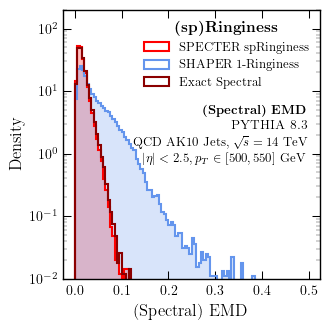

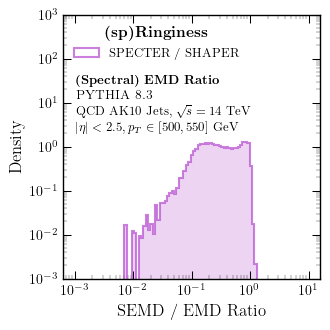

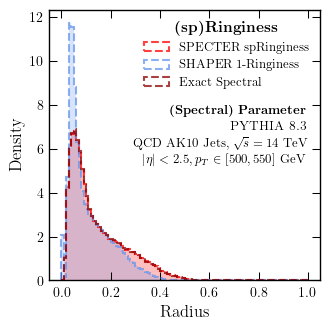

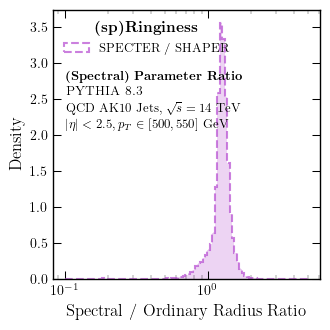

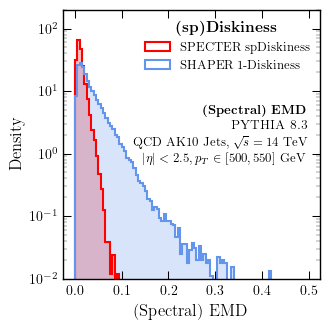

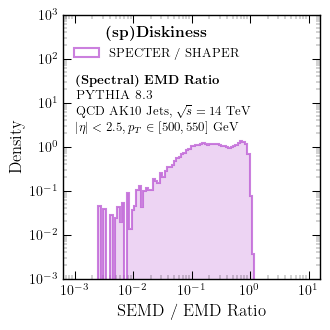

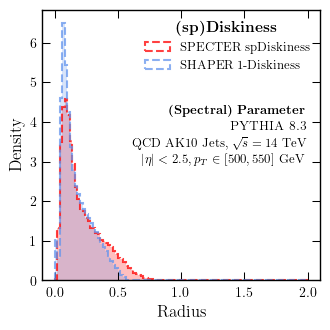

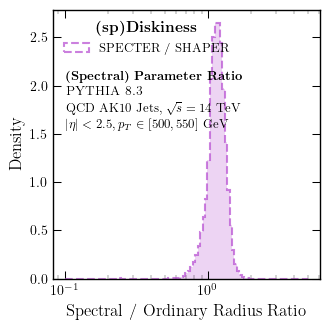

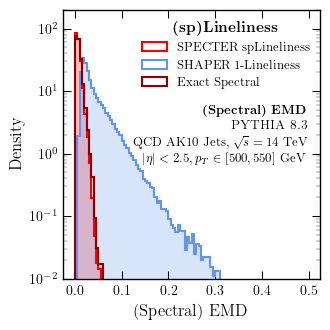

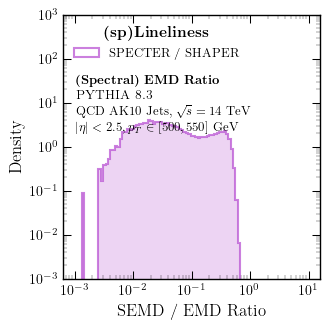

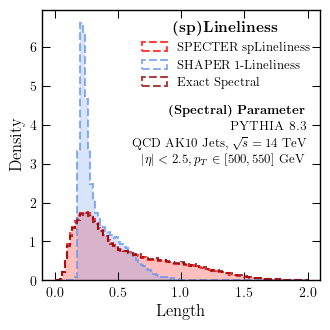

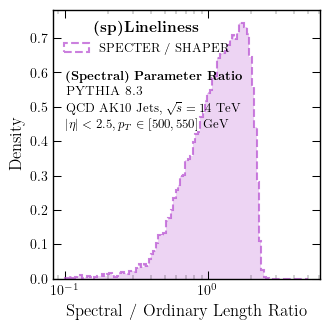

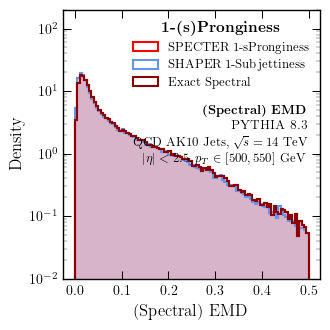

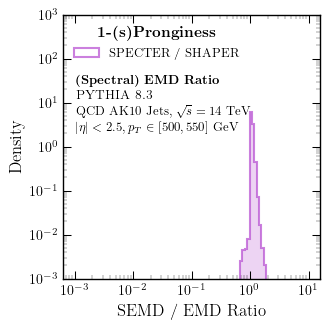

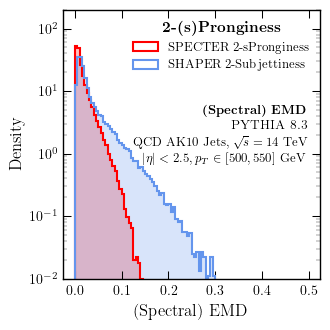

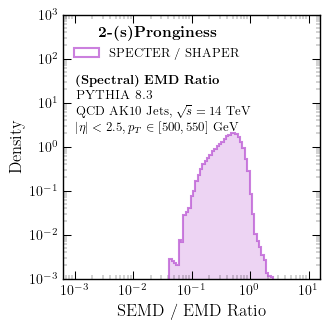

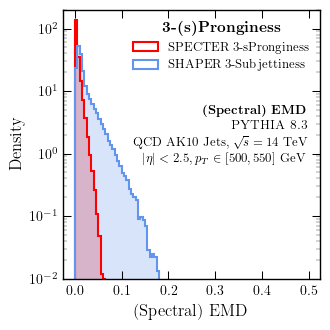

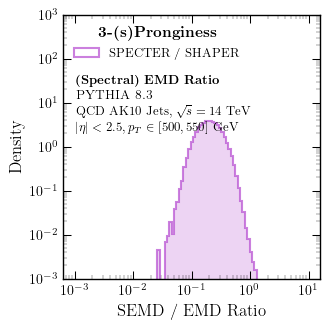

In [18]:

# observables = ["ring", "disk", "line", "1sprong", "2sprong", "3sprong"]
# observables_names = ["spRinginess", "spDiskiness", "spLineliness", "1-sPronginess", "2-sPronginess", "3-sPronginess"]
# param_names = ["Radius", "Radius", "Length", "", "", "",]




emd_ranges = [(0, 0.5), (0, 0.5), (0, 0.5), (0, 0.5), (0, 0.5), (0, 0.5)]
titles = [r"{\bf (sp)Ringiness}", r"{\bf (sp)Diskiness}", r"{\bf (sp)Lineliness}", r"{\bf 1-(s)Pronginess}", r"{\bf 2-(s)Pronginess}", r"{\bf 3-(s)Pronginess}"]

parameter_ranges = [(0, 1.0), (0, 2.0), (0, 2.0), (0, 1), (0, 1), (0, 1)]
parameter_linestyle = ["--", "--", "--", "--", "--", "--"]

# make fontsize 9 instead of 10 to save space
text_fontsize = 9


corr = 4 
for (i, observable) in enumerate(observables):



    # Observable (S)EMD Plot

    fix, ax = newplot("column")

    specter_label = r"${\rm SPECTER}$ " + observables_names[i]
    shaper_label = r"${\rm SHAPER}$ " + shaper_observables_names[i]

    hist_with_outline(ax, emds_dict[observable], bins=100, range = emd_ranges[i], color= SPECTER_COLOR, label=specter_label, density=True, alpha_2 = 1.0, lw = HISTOGRAM_LINEWIDTH)
    hist_with_outline(ax, corr *  shaper_emds_dict[shaper_observables[i]], bins=100, range = emd_ranges[i], color= SHAPER_COLOR, label=shaper_label, density=True,  alpha_2 = 1.0, lw = HISTOGRAM_LINEWIDTH)

    if hard_emds_dict[observable] != []:
        hist_with_outline(ax, hard_emds_dict[observable], bins=100, range = emd_ranges[i], color=HARD_SPECTER_COLOR, label="Exact Spectral", density=True, alpha_1= 0, alpha_2 = 1.0, lw = HISTOGRAM_LINEWIDTH)



    plt.xlabel("(Spectral) EMD")
    plt.ylabel("Density")
    plt.yscale("log")
    plt.ylim(1e-2, 200)

    plt.legend(loc = "upper right", title = titles[i], fontsize = text_fontsize)

    qcd_stamp(ax, "(Spectral) EMD", 0.95, 0.65, ha = "right", va = "top", text_fontsize = text_fontsize)

    plt.savefig(f"Figures/{observable}_emd.pdf")


    # Ratio (S)EMD Plot

    min_size = min(len(emds_dict[observable]), len(shaper_emds_dict[shaper_observables[i]]))
    ratios = emds_dict[observable][:min_size] / (corr *  shaper_emds_dict[shaper_observables[i]][:min_size])
    fig, ax = newplot("column")


    hist_with_outline(ax, ratios, bins=np.logspace(-3, np.log10(10), 100), range = (0, 10), color= "mediumorchid", label= r"${\rm SPECTER}$ "+ " / " + r"${\rm SHAPER}$ ", density=True, lw = HISTOGRAM_LINEWIDTH)
    plt.legend(loc = "upper left", title = titles[i], fontsize = text_fontsize)
    plt.xlabel("SEMD / EMD Ratio")
    plt.ylabel("Density")
    plt.xscale("log")
    plt.yscale("log")

    plt.ylim(1e-3, 1e3)


    qcd_stamp(ax, "(Spectral) EMD Ratio", 0.05, 0.775, ha = "left", va = "top", text_fontsize = text_fontsize)

    print(observable, "mean = ", emds_dict[observable].mean())
    print(observable, "ratio mean = ", ratios.mean())

    if observable == "1sprong":
        print(ratios.mean(), ratios)

    plt.savefig(f"Figures/{observable}_ratio.pdf")


    # Check if there is a parameter to plot
    if len(params_dict[observable]) > 0:
        fig, ax = newplot("column")
        
        # Histogram of Parameters
        hist_with_outline(ax, params_dict[observable], bins=100, range = parameter_ranges[i], color=SPECTER_COLOR, label=specter_label, density=True, linestyle = parameter_linestyle[i], lw = HISTOGRAM_LINEWIDTH)
        hist_with_outline(ax, shaper_params_dict[shaper_observables[i]], bins=100, range = parameter_ranges[i], color=SHAPER_COLOR, label=shaper_label, density=True, linestyle = parameter_linestyle[i], lw = HISTOGRAM_LINEWIDTH)


        if hard_params_dict[observable] != []:
            hist_with_outline(ax, hard_params_dict[observable], bins=100, range = parameter_ranges[i], color=HARD_SPECTER_COLOR, label="Exact Spectral", density=True, linestyle = parameter_linestyle[i], alpha_1= 0, lw = HISTOGRAM_LINEWIDTH)



        plt.xlabel(param_names[i])
        plt.ylabel("Density")
        # plt.yscale("log")
        # plt.ylim(1e-3, 1e3)


        plt.legend(loc = "upper right", title = titles[i], fontsize = text_fontsize)

        qcd_stamp(ax, f"(Spectral) Parameter", 0.95, 0.65, ha = "right", va = "top", text_fontsize = text_fontsize)

        plt.savefig(f"Figures/{observable}_param.pdf")


        min_size = min(len(emds_dict[observable]), len(shaper_emds_dict[shaper_observables[i]]))
        print(params_dict[observable][:min_size].shape, shaper_params_dict[shaper_observables[i]][:min_size,0].shape)
        ratios = params_dict[observable][:min_size] / shaper_params_dict[shaper_observables[i]][:min_size,0]
        print(ratios.shape)
        fig, ax = newplot("column")


        hist_with_outline(ax, ratios, bins=np.logspace(-1, np.log10(5), 100), range = (0, 5), color="mediumorchid", label=r"${\rm SPECTER}$ "+ " / " + r"${\rm SHAPER}$ ", density=True, linestyle = parameter_linestyle[i], lw = HISTOGRAM_LINEWIDTH)
        plt.xlabel(f"Spectral / Ordinary {param_names[i]} Ratio")
        plt.ylabel("Density")
        plt.xscale("log")
        # plt.yscale("log")
        plt.legend(loc = "upper left", title = titles[i], fontsize = text_fontsize)
        # plt.ylim(1e-2, 1e3)



        qcd_stamp(ax, f"(Spectral) Parameter Ratio", 0.05, 0.775, ha = "left", va = "top", text_fontsize = text_fontsize)

        plt.savefig(f"Figures/{observable}_param_ratio.pdf")





# EVENT SHAPES


In [26]:
# Combine all batched numpy files

observable_keys = ["ring", "isotropy", "thrust", "dipole"]
param_names = ["", "", "", "", "", "",]



for (o, observable_name) in enumerate(observable_keys):

    # observable_name = observable_names[o]

    emds = []
    params = []

    hard_emds = []
    hard_params = []

    for i in range(10):

        emds.append(np.load(f"{this_dir}/Data/ee_dijets_{observable_name}_emds_{i}.npy", allow_pickle = True))

        if param_names[o] != "":
            params.append(np.load(f"{this_dir}/Data/ee_dijets_{observable_name}_params_{i}.npy", allow_pickle = True).item()[param_names[o]])

        try:
            hard_emds.append(np.load(f"{this_dir}/Data/ee_dijets_{observable_name}_hard_emds_{i}.npy", allow_pickle = True))

            if param_names[o] != "":
                hard_params.append(np.load(f"{this_dir}/Data/ee_dijets_{observable_name}_hard_params_{i}.npy", allow_pickle = True).item()[param_names[o]])

        except:
            pass

    print(params)
    emds = np.concatenate(emds, axis = 0)

    if param_names[o] != "":
        params = np.concatenate(params, axis = 0) 


    np.save(f"{this_dir}/Data/ee_dijets_{observable_name}_emds.npy", emds)
    np.save(f"{this_dir}/Data/ee_dijets_{observable_name}_params.npy", params)

    try:


        hard_emds = np.concatenate(hard_emds, axis = 0)

        if param_names[o] != "":
            hard_params = np.concatenate(hard_params, axis = 0) 

        np.save(f"{this_dir}/Data/ee_dijets_{observable_name}_hard_emds.npy", hard_emds)
        np.save(f"{this_dir}/Data/ee_dijets_{observable_name}_hard_params.npy", hard_params)

    except:
        pass

[]
[]
[]
[]


In [27]:
# Load 

folder = "Data"
observables = ["ring", "isotropy", "thrust", "dipole"]
observables_names = ["spRinginess", "spIsotropy", "sThrust", "sDipole"]
param_names = ["", "", "", "", "", "",]
corr_factors = [1, 1/(np.pi - 2), 1 * 2 / np.pi**2]

this_dir = "/n/home01/rikab/SPECTER_STUDIES"

emds_dict = {}
params_dict = {}

hard_emds_dict = {}
hard_params_dict = {}




for (i, observable) in enumerate(observables):
    emds_dict[observable] = np.load(f"{folder}/ee_dijets_{observable}_emds.npy") * corr_factors[i]

    try:
        dict_ = np.load(f"{folder}/ee_dijets_{observable}_params.npy", allow_pickle=True).item()
        params_dict[observable] = dict_[param_names[i]]
    except:
        params_dict[observable] = []

    try:
        hard_emds = np.load(f"{folder}/ee_dijets_{observable}_hard_emds.npy") * corr_factors[i]
        hard_emds_dict[observable] = hard_emds
        print("o ", observable, hard_emds.shape)

        hard_params = np.load(f"{folder}/ee_dijets_{observable}_hard_params.npy")
        hard_params_dict[observable] = hard_params
        print("p ", observable, hard_params.shape)
    except:
        hard_emds_dict[observable] = []
        hard_params_dict[observable] = []


o  ring (100000,)
p  ring (0,)
o  isotropy (100000,)
p  isotropy (0,)


In [28]:
shaper_emds_dict = {}

# load np array from txt file
thrust_array = np.loadtxt("Data/thrust.txt")
np.save(f"{folder}/pot_thrust_emds.npy",  ( 1 - thrust_array))

for (i, observable) in enumerate(observables):

    try:
        if observable != "dipole":
            shaper_emds_dict[observable] = np.array(np.load(f"{this_dir}/Data/pot_{observable}_emds.npy"))
        if observable == "isotropy":
            shaper_emds_dict[observable] = shaper_emds_dict[observable] / np.max(shaper_emds_dict[observable])
        if observable == "dipole":
            shaper_emds_dict[observable] = np.array(np.load(f"{this_dir}/Data/pot_thrust_emds.npy"))
    except:
        shaper_emds_dict[observable] = []





ring [0.53138685 0.4492383  0.02757645 ... 0.451694   0.47026587 0.58711624]


/tmp/ipykernel_2035010/1359249818.py:23: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if hard_emds_dict[observable] != []:
/tmp/ipykernel_2035010/1359249818.py:33: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(-3, 200)


isotropy [0.7149295  0.6280315  0.02867724 ... 0.63148916 0.64789116 0.7689466 ]


/tmp/ipykernel_2035010/1359249818.py:23: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if hard_emds_dict[observable] != []:
/tmp/ipykernel_2035010/1359249818.py:26: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if shaper_emds_dict[observable] != []:
/tmp/ipykernel_2035010/1359249818.py:33: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(-3, 200)
/tmp/ipykernel_2035010/1359249818.py:41: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if shaper_emds_dict[observable] != []:


0.686796000664289
thrust [0.01104065 0.01754387 0.20460148 ... 0.02442664 0.02098902 0.00892142]


/tmp/ipykernel_2035010/1359249818.py:26: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if shaper_emds_dict[observable] != []:
/tmp/ipykernel_2035010/1359249818.py:33: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(-3, 200)
/tmp/ipykernel_2035010/1359249818.py:41: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if shaper_emds_dict[observable] != []:


0.8643986119443562


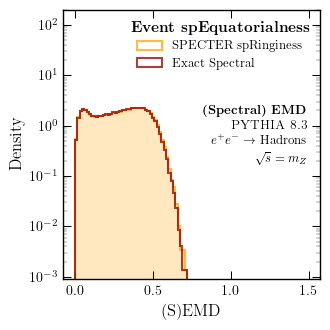

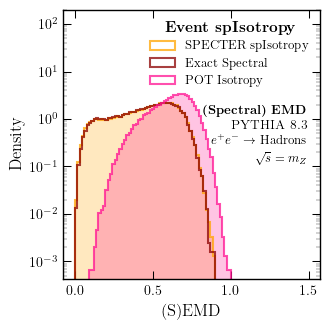

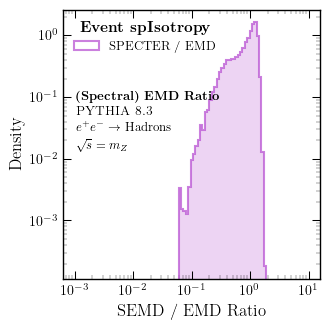

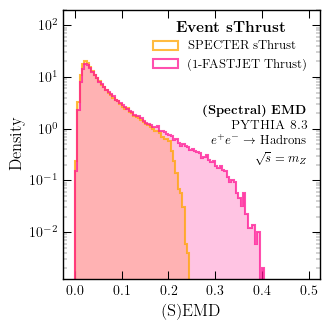

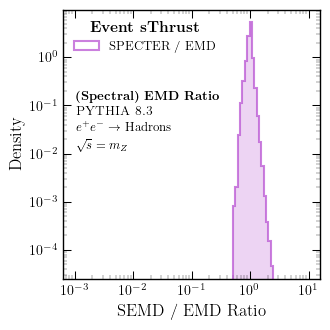

In [30]:
# folder = "Data"
# observables = ["ring", "isotropy", "thrust"]
# observables_names = ["spRinginess", "spIsotropy", "sThrust", ]
# param_names = ["", "", "", "", "", "",]

emd_ranges = [(0, 1.5), (0, 1.5), (0, 0.5), (0, 0.5), (0, 0.35), (0, 0.1), (0, 0.05)]
titles = [r"{\bf Event spEquatorialness}", r"{\bf Event spIsotropy}", r"{\bf Event sThrust}", r"{\bf Event Chord-sThrust}", r"{\bf 1-(s)Pronginess}", r"{\bf 2-(s)Pronginess}", r"{\bf 3-(s)Pronginess}"]
shaper_names = ["Ordinary Equatorialness", "POT Isotropy", r"(1-FASTJET Thrust)", r"(1-FASTJET Thrust)", "1-Ringiness", "2-Ringiness", "3-Ringiness"]
text_fontsize = 9



for (i, observable) in enumerate(observables):


    specter_label = r"${\rm SPECTER}$ " + observables_names[i]
    fix, ax = newplot("column")

    print(observable, emds_dict[observable])

    hist_with_outline(ax, emds_dict[observable], bins=100, range = emd_ranges[i], color="orange", label=specter_label, density=True, lw = HISTOGRAM_LINEWIDTH)

    if hard_emds_dict[observable] != []:
        hist_with_outline(ax, hard_emds_dict[observable], bins=100, range = emd_ranges[i], color="darkred", label="Exact Spectral", density=True, alpha_1= 0, lw = HISTOGRAM_LINEWIDTH)

    if shaper_emds_dict[observable] != []:
        hist_with_outline(ax,  shaper_emds_dict[observable], bins=100, range = emd_ranges[i], color=POT_COLOR, label=shaper_names[i], density=True, lw = HISTOGRAM_LINEWIDTH)

    plt.xlabel("(S)EMD")
    plt.ylabel("Density")
    plt.yscale("log")

    plt.ylim(-3, 200)

    plt.legend(loc = "upper right", title = titles[i], fontsize = text_fontsize)

    ee_stamp(ax, "(Spectral) EMD", 0.95, 0.65, ha = "right", va = "top", text_fontsize = text_fontsize)

    plt.savefig(f"Figures/ee_dijets_{observable}_emd.pdf")

    if shaper_emds_dict[observable] != []:

        min_size = 100000
        ratios = emds_dict[observable][:min_size] / ( shaper_emds_dict[observable][:min_size])
        fig, ax = newplot("column")

        print(np.mean(ratios))

        hist_with_outline(ax, ratios / np.mean(ratios), bins=np.logspace(-3, np.log10(10), 100), range = (0, 10), color="mediumorchid", label= r"${\rm SPECTER}$ "+ " / " + r"${\rm EMD}$ ", density=True, lw = HISTOGRAM_LINEWIDTH)
        plt.legend(loc = "upper left", title = titles[i], fontsize = text_fontsize)
        plt.xlabel("SEMD / EMD Ratio")
        plt.ylabel("Density")
        plt.xscale("log")
        plt.yscale("log")

        ee_stamp(ax, "(Spectral) EMD Ratio", 0.05, 0.70, ha = "left", va = "top", text_fontsize = text_fontsize)


        if observable == "1sprong":
            print(ratios.mean(), ratios)

        plt.savefig(f"Figures/ee_dijets_{observable}_ratio.pdf")




# Pairwise EMDS

0.9877545413660963
0.9353989692080393
0.9317759806665485
0.9704003828694153
0.9994098514691555
0.8216266667634763
-0.11590365853212446
0.8773711025218337
-0.15131555075030648


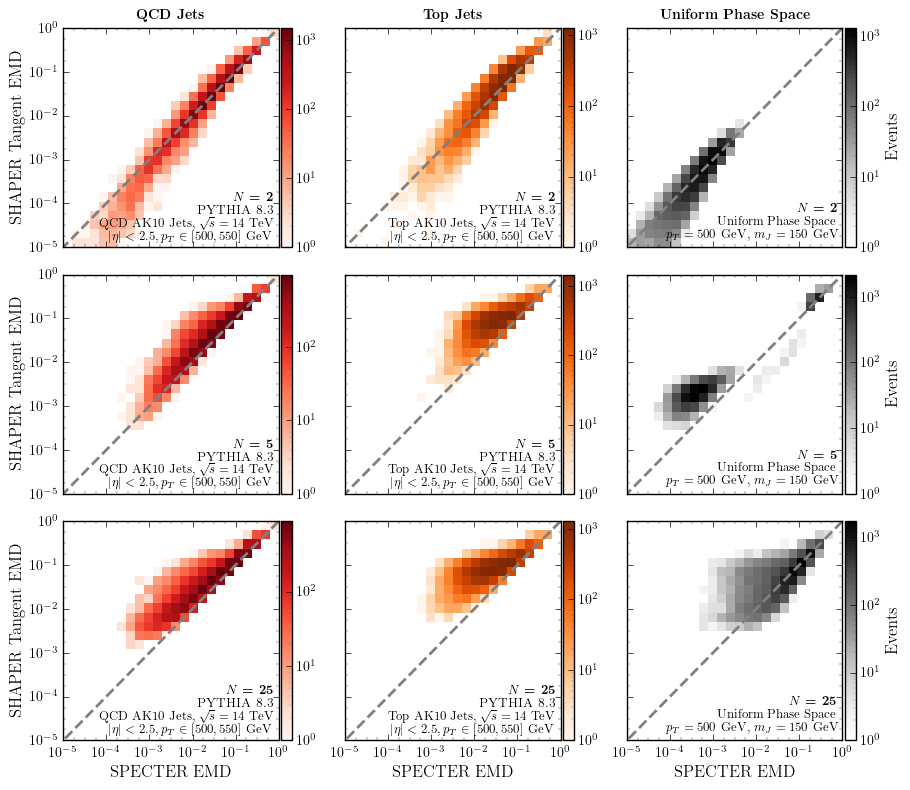

In [24]:
import matplotlib



def plot(ax, dataset_name, N_jets):


    specter_emds = np.load(f"Data/{dataset_name}_specter_emds_{N_jets}jets.npy")
    shaper_emds = np.load(f"Data/{dataset_name}_shaper_emds_{N_jets}jets.npy")
    # log 2d histogram

    log = True
    xbins = np.logspace(-5, 0, 25)
    ybins = np.logspace(-5, 0, 25)


    if dataset_name == "qcd":
        qcd_stamp(ax, rf"$N$ = {N_jets}", 0.975, 0.20, ha = "right", va = "bottom", text_fontsize= 9 )
        cmap = "Reds"
    elif dataset_name == "top":
        top_stamp(ax, rf"$N$ = {N_jets}", 0.975, 0.20, ha = "right", va = "bottom", text_fontsize= 9 )
        cmap = "Oranges"
    elif dataset_name == "RAMBO":
        rambo_stamp(ax, rf"$N$ = {N_jets}", 0.975, 0.15, ha = "right", va = "bottom", text_fontsize= 9 )
        cmap = "Greys"
    



    if log:
        hist = ax.hist2d(specter_emds, shaper_emds, norm = matplotlib.colors.LogNorm(), bins = [xbins, ybins], density=False, cmap = cmap)
    else:
        hist = ax.hist2d(specter_emds, shaper_emds, bins = [xbins, ybins], density=False, cmap = cmap)
    # diagonal line
    x = np.linspace(0, 10, 1000)
    ax.plot(x, x, color = "grey", lw = 2, ls = "--")

    # ax.set_xlabel("SPECTER EMD")
    # ax.set_ylabel(r"SHAPER EMD / (Isometries)")
    plt.xscale("log")
    plt.yscale("log")

    # add colorbar
    # ax.set_aspect('equal')
    cbar = plt.colorbar(hist[3], ax = ax, ticks = [1, 10, 100, 1000], pad = 0.01)
    cbar.ax.tick_params(labelsize=10, width = 0.5, which = "major", length = 4)
    cbar.ax.tick_params(width = 0.1, which = "minor", length = 2)

    # Colorbar outline width
    cbar.outline.set_linewidth(1)

    if dataset_name == "RAMBO":
        cbar.set_label("Events", fontsize = 12)

    # Change colorbar size 
    

    # cbabr = ax.colorbar()
    # cbabr.set_label("Events")

    # Calculate the pearson correlation coefficient
    pearson = np.corrcoef(specter_emds, shaper_emds)[0,1]
    print(pearson)
    # pearson = np.log(1 - pearson**2)
    # plt.text(0.75, 0.05, rf"Pearson Correlation $\log(1-\rho^2) = $ {np.log(1-pearson**2):.3f}", transform=ax.transAxes)



    plt.savefig(f"Figures/{dataset_name}_emd_{N_jets}jets.pdf")




fig, ax = plt.subplots(3, 3, sharex = "all", sharey = "all", figsize = (8*1.15, 8))
# ax.__setattr__("sharex", "all")
# ax.__setattr__("sharey", "all")



for (i, N_jets) in enumerate([2, 5, 25]):


    plot(ax[i,0], "qcd", N_jets)
    plot(ax[i,2], "RAMBO", N_jets)
    plot(ax[i,1], "top", N_jets)

# only have labels on the outer plots
for i in range(3):
    ax[i,0].set_ylabel("SHAPER Tangent EMD", fontsize = 12)
    ax[0,0].set_title(r"$\textbf{QCD Jets}$")
    ax[0,1].set_title(r"$\textbf{Top Jets}$")
    ax[0,2].set_title(r"$\textbf{Uniform Phase Space}$")
    ax[2,0].set_xlabel("SPECTER EMD", fontsize = 12)
    ax[2,1].set_xlabel("SPECTER EMD", fontsize = 12)
    ax[2,2].set_xlabel("SPECTER EMD", fontsize = 12)

# set border width
for i in range(3):
    for j in range(3):
        for axis in ['top','bottom','left','right']:
            ax[i,j].spines[axis].set_linewidth(1)

fig.tight_layout()



# at least 4 x and y markers
for i in range(3):
    for j in range(3):
        
        bins = np.logspace(-5, 0, 6)
        ax[i,j].set_xticks(bins)
        ax[i,j].set_yticks(bins)

        ax[i,j].xaxis.set_tick_params(width=0.5, length = 4)
        ax[i,j].yaxis.set_tick_params(width=0.5, length = 4)

        ax[i,j].tick_params(axis='both', which='major', labelsize=10)

        # Minor ticks 
        minor_bins = np.logspace(-5, 0, 21)
        ax[i,j].set_xticks(minor_bins, minor=True)
        ax[i,j].set_yticks(minor_bins, minor=True)

        ax[i,j].xaxis.set_tick_params(width=0.25, which = "minor", length = 2)
        ax[i,j].yaxis.set_tick_params(width=0.25, which = "minor", length = 2)


plt.savefig("Figures/emd_comparison.pdf")


# 2-(s)Pronginess Parameter Space

In [25]:
# Load SPECTER

observable = "2sprong"
p = np.load(f"{folder}/{observable}_params.npy", allow_pickle=True).item()["Points"]
specter_zs = p[:,0,0]
specter_zs = np.minimum(specter_zs, 1-specter_zs)
specter_ps = np.sqrt(np.sum(np.square(p[:,0,1:] - p[:,1,1:]) , axis = 1) )


# Load SHAPER
observable = "2-Subjettiness"
p = np.load(f"{this_dir}/{shaper_folder}/{observable}_params.npy", allow_pickle=True)
shaper_zs = []
shaper_ps = []
for i in p:
    points = i["Points"]
    shaper_ps.append(np.sqrt(np.sum(np.square(points[0] - points[1]) , axis = 0)))

    weights = i["Weights"]
    shaper_zs.append(np.minimum(weights[0], 1-weights[0]))

shaper_zs = np.array(shaper_zs)
shaper_ps = np.array(shaper_ps)

N_plot = 15000

fig, ax = newplot("column")
plt.scatter(specter_zs[:N_plot], specter_ps[:N_plot], color = "red", alpha = 0.05)
plt.scatter(shaper_zs[:N_plot], shaper_ps[:N_plot], color = "mediumorchid", alpha = 0.05)

plt.xlabel(r"Min $z$")
plt.ylabel(r"Seperation $\theta$")
# cms_stamp(r"Parameter Distribution", 0.95, 0.70, ha = "right", va = "top")

# Draw legend with a white box around it

# Add fake points with no alpha for the legend
plt.scatter([], [], color = "red", label = r"${\rm SPECTER}$", alpha = 1)
plt.scatter([], [], color = "mediumorchid", label = r"${\rm SHAPER}$", alpha = 1)
plt.legend(loc = "upper right", fontsize = text_fontsize, facecolor='white', framealpha=1, frameon = True,)




plt.savefig(f"Figures/2sprong_param.pdf")

ValueError: can only convert an array of size 1 to a Python scalar

In [ ]:
EMDs = np.load("Data/degeneracy_EMDs.npy")
SEMDs = np.load("Data/degeneracy_SEMDs.npy")
SEMDs_new = np.load("Data/degeneracy_SEMDs_new.npy")



num_angles = 180


angles = np.linspace(0, np.pi, num_angles)

fig, ax = newplot("column")


plt.plot(angles,  (np.array(EMDs[:,120])), color = "black", label = r"2-Subjettiness$^{\beta = 2}$", lw = 2)
plt.plot(angles, SEMDs_new[:,120] - (SEMDs_new[0,120]), color = "red", label = "2-sPronginess", lw = 2)
plt.axvline(np.pi / 3, color = "grey", ls = "--")
plt.legend(frameon = False, loc = "upper left", )

plt.ylim(0, 0.1)

# tickmarks at 0, pi/6 pi/3, pi/2, 2pi/3, 5pi/6, pi
plt.xticks([0, np.pi/6, np.pi/3, np.pi/2, 2*np.pi/3, 5*np.pi/6, np.pi], ["0", r"$\pi/6$", r"$\pi/3$", r"$\pi/2$", r"$2\pi/3$", r"$5\pi/6$", r"$\pi$"])

plt.xlabel("Opening Angle [Rad]")
plt.ylabel("Observable")

plt.savefig("Figures/degeneracy.pdf")